### In this notebook developed BBC News **classification** using TF-IDF and Word2Vec text representation.

### Methods for the classification are Logistic Regression, Decision tree, Random forest, SVM, XGBoost

### TF-IDF vs Word2Vec

TF-IDF (term frequency-inverse document frequency) and Word2Vec are popular algorithms used in natural language processing, but they serve different purposes.

TF-IDF is a simple and widely used method for text representation. It assigns weights to words in a document based on their frequency in the document and inverse frequency in the corpus. The idea is that words that are frequent in a document but rare in the corpus are likely to be important for that document’s meaning. This approach is commonly used for information retrieval and text classification tasks.

Word2Vec, on the other hand, is a more complex algorithm that learns vector representations (embeddings) of words based on their context in a large corpus of text. These embeddings show how words are related semantically and grammatically. They can be used for various natural language processing tasks, such as finding word analogies and similar words and putting texts into groups.

So, when it comes to text classification specifically, which one is better? The answer is it depends on the task and the data.

TF-IDF is a good choice when the documents in the dataset are relatively short and the vocabulary size is small. It is also computationally efficient and can handle large datasets. However, TF-IDF needs to capture the meaning of words or their relationships, so it may not be adequate for some text classification tasks.

Word2Vec, on the other hand, is better suited for larger and more complex datasets, where words have multiple meanings and relationships between them are essential. It is particularly effective when the task involves identifying similarities or relationships between documents, such as clustering or document retrieval. However, Word2Vec requires a large amount of data and computational resources to train, and it may perform poorly when limited training data is available.

In summary, both TF-IDF and Word2Vec have their strengths and weaknesses, and the choice of algorithm depends on the specific task, the data, and available resources.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from gensim.models import Word2Vec
import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
clean_text = pd.read_csv('/content/drive/MyDrive/Text Mining Project/clean_text.csv')

In [4]:
clean_text.head()

,category,article_id,text
0,business,73,"['german', 'growth', 'goe', 'revers', 'germani..."
1,business,352,"['share', 'boost', 'feud', 'hit', 'relianc', '..."
2,business,279,"['german', 'bidder', 'talk', 'lse', 'deutsch',..."
3,business,447,"['news', 'corp', 'eye', 'video', 'game', 'mark..."
4,business,242,"['q', 'malcolm', 'glazer', 'man', 'utd', 'batt..."


Splitting dataset for the training and test sets before applying TfidfVectorizer. By splitting our dataset first and then applying TF-IDF separately to the training and test sets, we ensure that our model generalizes well to unseen data.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(clean_text['text'], clean_text['category'], test_size=0.2, random_state=42)

In [6]:
X_train.head()

23      ['call', 'save', 'manufactur', 'job', 'trade',...
1903    ['microsoft', 'releas', 'patch', 'microsoft', ...
427     ['huge', 'rush', 'jet', 'airway', 'share', 'in...
554     ['jail', 'singer', 'courtney', 'love', 'singer...
1767    ['white', 'admit', 'balco', 'drug', 'link', 'b...
Name: text, dtype: object

In [7]:
print(f"Size of input training features is {X_train.shape}")
print(f"Size of input test features is {X_test.shape}")
print(f"Size of output training labels is {y_train.shape}")
print(f"Size of output test labels is {y_test.shape}")

Size of input training features is (1779,)
Size of input test features is (445,)
Size of output training labels is (1779,)
Size of output test labels is (445,)


In [8]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [9]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
for category, label in label_mapping.items():
    print(f"{category}: {label}")

Label Mapping:
business: 0
entertainment: 1
politics: 2
sport: 3
tech: 4


### TF-IDF Vectorizer
Convert a collection of raw documents to a matrix of TF-IDF features.
When transforming the test set using the TF-IDF vectorizer, we use the same vectorizer instance that was fit on the training set. This ensures consistency in the transformation process. We don't fit a new vectorizer on the test set, as it may introduce information from the test set into the model training process, leading to data leakage.

In [10]:
# Create the TF-IDF vectorizer and fit it on the training set
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [11]:
X_train_tfidf.shape

(1779, 17443)

In [12]:
X_test_tfidf.shape

(445, 17443)

In [13]:
# Convert the TF-IDF matrix to a pandas DataFrame for better readability
terms = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=terms)

### Word2Vec

In [14]:
X_train_list = X_train.apply(ast.literal_eval).tolist()
X_test_list = X_test.apply(ast.literal_eval).tolist()

In [15]:
X_train.head()

23      ['call', 'save', 'manufactur', 'job', 'trade',...
1903    ['microsoft', 'releas', 'patch', 'microsoft', ...
427     ['huge', 'rush', 'jet', 'airway', 'share', 'in...
554     ['jail', 'singer', 'courtney', 'love', 'singer...
1767    ['white', 'admit', 'balco', 'drug', 'link', 'b...
Name: text, dtype: object

In [16]:
word2vec_model = Word2Vec(sentences=X_train_list, vector_size=100, window=3, min_count=1, workers=4)

In [17]:
X_train_word2vec = [word2vec_model.wv[word] for word in X_train_list]
X_test_word2vec = [
    [word2vec_model.wv[word] if word in word2vec_model.wv else [0] * word2vec_model.vector_size for word in sentence]
    for sentence in X_test_list
]

In [18]:
len(X_train_word2vec[0])

110

In [19]:
X_train_word2vec[0:2]

[array([[-0.512667  ,  0.47407603,  0.2769729 , ..., -0.7091385 ,
         -0.55814135, -0.58381236],
        [-0.49617082,  0.4497134 ,  0.21586534, ..., -0.618703  ,
          0.00727014, -0.13810955],
        [-0.44743824,  0.34670177,  0.18040629, ..., -0.5645348 ,
          0.06803077, -0.08954792],
        ...,
        [-0.6771078 ,  0.34198055,  0.35456142, ..., -0.5330733 ,
          0.05672456, -0.4737484 ],
        [-0.44743824,  0.34670177,  0.18040629, ..., -0.5645348 ,
          0.06803077, -0.08954792],
        [-0.5174087 ,  0.3761263 ,  0.22118266, ..., -0.69374484,
         -0.0593505 , -0.2134541 ]], dtype=float32),
 array([[-0.6220534 ,  0.36299685,  0.27826074, ..., -0.67634296,
         -0.12218522, -0.3976517 ],
        [-0.44010937,  0.4656337 ,  0.00756378, ..., -0.67913145,
          0.6096799 ,  0.49215275],
        [-0.16342326,  0.13852672,  0.06278528, ..., -0.22302046,
          0.00300642, -0.04421066],
        ...,
        [-0.5740334 ,  0.40184152,  0.3

In [20]:
# Aggregate embeddings (using average along axis=0 to average along the word dimension)
# Stack the aggregated embeddings into a single array

X_train_aggregated = [np.mean(embeddings, axis=0) for embeddings in X_train_word2vec]
X_train_aggregated = np.vstack(X_train_aggregated)

X_test_aggregated = [np.mean(embeddings, axis=0) for embeddings in X_test_word2vec]
X_test_aggregated = np.vstack(X_test_aggregated)

In [21]:
X_test_aggregated[0]

array([-0.46129206,  0.30283093,  0.19124681, -0.01671195,  0.07893978,
       -0.6989431 ,  0.11632861,  0.71834922, -0.16455356, -0.07837053,
       -0.11570006, -0.53594364, -0.05346393,  0.06451627, -0.03973641,
       -0.33140418,  0.11396189, -0.36822496,  0.13791109, -0.78655673,
        0.19609341,  0.15311317,  0.31576137, -0.27657577, -0.02475061,
        0.06438999, -0.25556089, -0.14919489, -0.35128165, -0.15591526,
        0.44028372,  0.07685839, -0.08811341, -0.1376548 ,  0.01172961,
        0.34996296,  0.04296022, -0.18157134, -0.29761223, -0.63597203,
       -0.06309494, -0.34196856, -0.0798602 ,  0.0115733 ,  0.21933504,
       -0.12436082, -0.31898648,  0.07255327,  0.27711133,  0.33448053,
        0.05445192, -0.32536288, -0.15537821,  0.13389263, -0.55044507,
        0.02522832,  0.18346737,  0.0476405 , -0.60428017,  0.12463033,
        0.14998311,  0.10801161, -0.14076302,  0.04664287, -0.59320264,
        0.21233042,  0.05626844,  0.22339168, -0.30018694,  0.46

# Classification

In [22]:
def evaluation(y_test, y_pred, model):

  report = classification_report(y_test, y_pred)
  print("Classification Report:\n", report)

  conf_matrix = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(5, 4))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.show()

In [23]:
def modeling(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics = {
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }
    return model, y_pred, metrics


# Classification based on Tf-Idf

In [24]:
models = [
    ('LogReg', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('XGBoost', XGBClassifier()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('RanForest', RandomForestClassifier()),
]

In [25]:
results_tfidf = pd.DataFrame()
trained_models_dict = {}
predictions_dict = {}

# Evaluate each model and store the results in the DataFrame
for model_name, model in models:
    trained_model, y_pred, metrics = modeling(model, X_train_tfidf, y_train_encoded, X_test_tfidf, y_test_encoded)
    results_tfidf = results_tfidf.append({'Model': model_name, **metrics}, ignore_index=True)

    # Store the results in dictionaries
    trained_models_dict[model_name] = trained_model
    predictions_dict[model_name] = y_pred


In [26]:
results_tfidf

,Model,precision,recall,f1-score
0,LogReg,0.973407,0.973034,0.973020
1,SVM,0.980024,0.979775,0.979734
2,XGBoost,0.953341,0.952809,0.952727
3,DecisionTree,0.842460,0.842697,0.841384
4,RanForest,0.953342,0.952809,0.952749


## Detailed reports of classification

### Logistic Regression

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       113
           1       0.99      0.94      0.96        78
           2       0.93      0.97      0.95        69
           3       0.99      1.00      1.00       101
           4       0.98      0.96      0.97        84

    accuracy                           0.97       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445



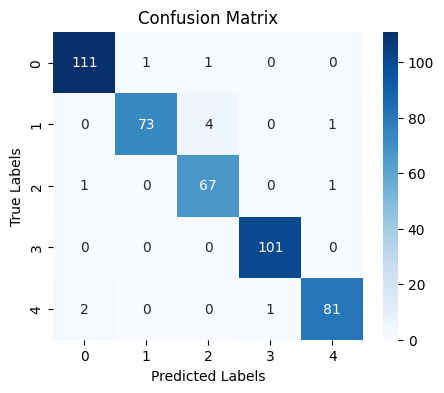

In [27]:
evaluation(y_test_encoded, predictions_dict.get('LogReg'), trained_models_dict.get('LogReg'))

### Decision Tree Classifier
Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       113
           1       0.74      0.76      0.75        78
           2       0.90      0.81      0.85        69
           3       0.89      0.98      0.93       101
           4       0.86      0.89      0.88        84

    accuracy                           0.84       445
   macro avg       0.84      0.84      0.84       445
weighted avg       0.84      0.84      0.84       445



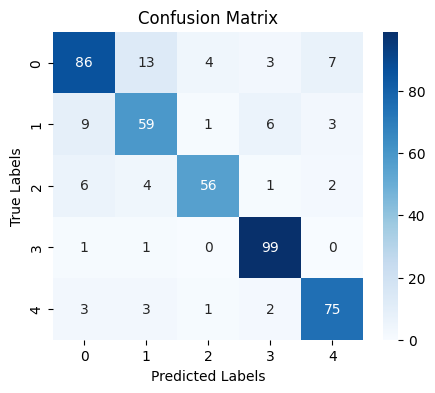

In [28]:
evaluation(y_test_encoded, predictions_dict.get('DecisionTree'), trained_models_dict.get('DecisionTree'))

### Random Forest Classifier
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       113
           1       1.00      0.94      0.97        78
           2       0.94      0.94      0.94        69
           3       0.95      1.00      0.98       101
           4       0.94      0.93      0.93        84

    accuracy                           0.95       445
   macro avg       0.95      0.95      0.95       445
weighted avg       0.95      0.95      0.95       445



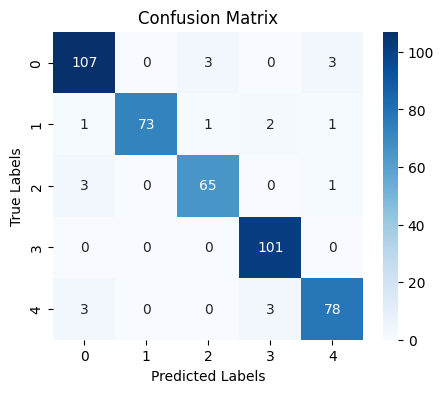

In [29]:
evaluation(y_test_encoded, predictions_dict.get('RanForest'), trained_models_dict.get('RanForest'))

### SVM Classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       113
           1       0.99      0.94      0.96        78
           2       0.94      0.97      0.96        69
           3       1.00      1.00      1.00       101
           4       0.99      0.99      0.99        84

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



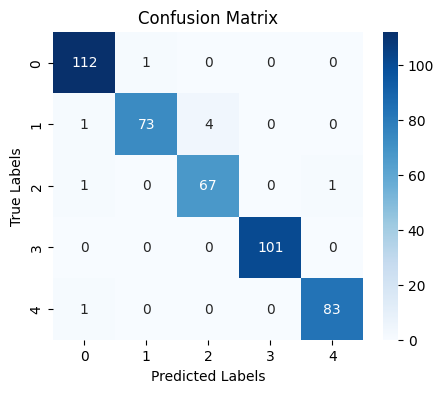

In [30]:
evaluation(y_test_encoded, predictions_dict.get('SVM'), trained_models_dict.get('SVM'))

### XGBoost Classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.95       113
           1       0.94      0.92      0.93        78
           2       0.94      0.96      0.95        69
           3       0.98      0.99      0.99       101
           4       0.92      0.98      0.95        84

    accuracy                           0.95       445
   macro avg       0.95      0.95      0.95       445
weighted avg       0.95      0.95      0.95       445



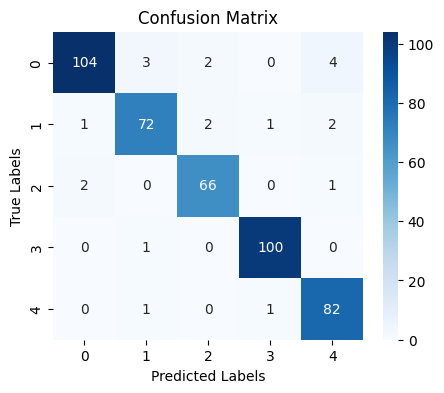

In [31]:
evaluation(y_test_encoded, predictions_dict.get('XGBoost'), trained_models_dict.get('XGBoost'))

# Classification based on Word2Vec

In [32]:
results_W2V = pd.DataFrame()
trained_models_dict_W2V = {}
predictions_dict_W2V = {}

# Evaluate each model and store the results in the DataFrame
for model_name, model in models:
    trained_model, y_pred, metrics = modeling(model, X_train_aggregated, y_train_encoded, X_test_aggregated, y_test_encoded)
    results_W2V = results_W2V.append({'Model': model_name, **metrics}, ignore_index=True)

    # Store the results in dictionaries
    trained_models_dict_W2V[model_name] = trained_model
    predictions_dict_W2V[model_name] = y_pred


In [33]:
results_W2V

,Model,precision,recall,f1-score
0,LogReg,0.890394,0.887640,0.887059
1,SVM,0.876839,0.874157,0.873003
2,XGBoost,0.919958,0.919101,0.918474
3,DecisionTree,0.890841,0.883146,0.884685
4,RanForest,0.899379,0.898876,0.897797


## Detailed reports of classification

### Logistic Regression

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       113
           1       0.94      0.78      0.85        78
           2       0.81      0.90      0.85        69
           3       0.92      0.97      0.94       101
           4       0.90      0.86      0.88        84

    accuracy                           0.89       445
   macro avg       0.89      0.88      0.88       445
weighted avg       0.89      0.89      0.89       445



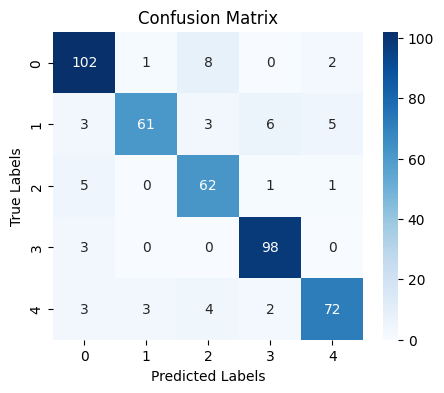

In [34]:
evaluation(y_test_encoded, predictions_dict_W2V.get('LogReg'), trained_models_dict_W2V.get('LogReg'))

### Decision Tree Classifier
Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90       113
           1       0.86      0.86      0.86        78
           2       0.73      0.91      0.81        69
           3       0.94      0.93      0.94       101
           4       0.93      0.83      0.88        84

    accuracy                           0.88       445
   macro avg       0.88      0.88      0.88       445
weighted avg       0.89      0.88      0.88       445



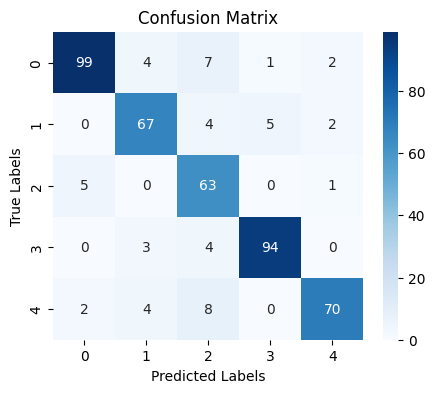

In [35]:
evaluation(y_test_encoded, predictions_dict_W2V.get('DecisionTree'), trained_models_dict_W2V.get('DecisionTree'))

### Random Forest Classifier
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       113
           1       0.90      0.79      0.84        78
           2       0.86      0.91      0.89        69
           3       0.92      0.98      0.95       101
           4       0.92      0.85      0.88        84

    accuracy                           0.90       445
   macro avg       0.90      0.89      0.89       445
weighted avg       0.90      0.90      0.90       445



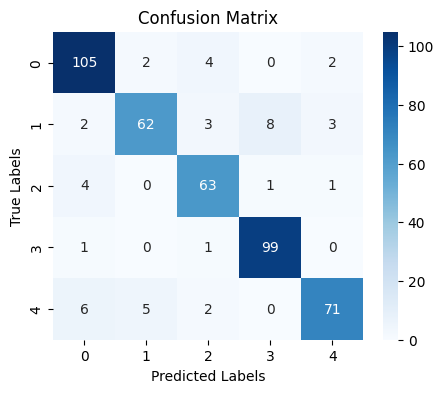

In [36]:
evaluation(y_test_encoded, predictions_dict_W2V.get('RanForest'), trained_models_dict_W2V.get('RanForest'))

### SVM

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       113
           1       0.90      0.78      0.84        78
           2       0.81      0.90      0.85        69
           3       0.90      0.97      0.93       101
           4       0.92      0.79      0.85        84

    accuracy                           0.87       445
   macro avg       0.88      0.87      0.87       445
weighted avg       0.88      0.87      0.87       445



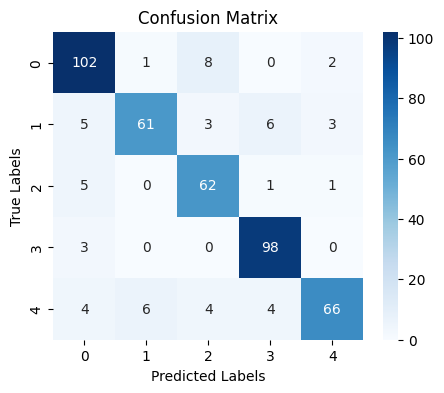

In [37]:
evaluation(y_test_encoded, predictions_dict_W2V.get('SVM'), trained_models_dict_W2V.get('SVM'))

### XGBoost Classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       113
           1       0.93      0.83      0.88        78
           2       0.88      0.93      0.90        69
           3       0.95      0.98      0.97       101
           4       0.94      0.87      0.90        84

    accuracy                           0.92       445
   macro avg       0.92      0.91      0.91       445
weighted avg       0.92      0.92      0.92       445



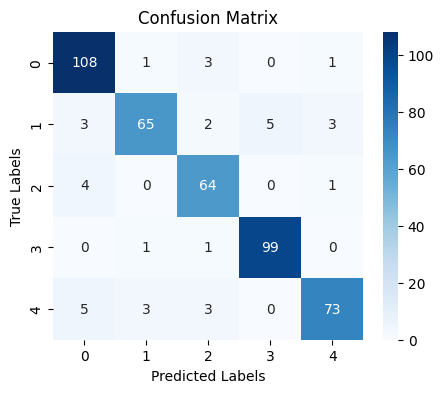

In [38]:
evaluation(y_test_encoded, predictions_dict_W2V.get('XGBoost'), trained_models_dict_W2V.get('XGBoost'))

# Conclusion

For better comparison let's consider F1 score for both approaches.

In [39]:
merged_df = pd.merge(results_tfidf[['Model', 'f1-score']], results_W2V[['Model', 'f1-score']], on='Model', suffixes=('_tfidf', '_w2v'))

In [41]:
merged_df['f1-score_tfidf'] = merged_df['f1-score_tfidf'].round(3)
merged_df['f1-score_w2v'] = merged_df['f1-score_w2v'].round(3)

In [42]:
merged_df

,Model,f1-score_tfidf,f1-score_w2v
0,LogReg,0.973,0.887
1,SVM,0.980,0.873
2,XGBoost,0.953,0.918
3,DecisionTree,0.841,0.885
4,RanForest,0.953,0.898


The main tendency is that text classification based on Tf-Idf gives better results and requires less computation than Word2Vec approach.

The best classification model for our dataset is SVM and Logistic regression.